In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import cohorts
from cohorts.functions import missense_snv_count
from query_tcga import cohort, config, cache
from query_tcga import query_tcga as qtcga
import logging
logging.basicConfig(level=logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating a Cohort

There are several ways to create a Cohort using [cohorts](http://github.com/hammerlab/cohorts).

The simplest of all possible scenarios is where you start with some clinical data, and wish to accumulate this into an analysis. 

For example, we are going to use `TCGA` data from the `BLCA` cohort (generated using the `get_clinical_data.py` command-line script available here), but we are reading this data in from a pipe-delimited file so it could have come from anywhere.

The point here is to demonstrate how to create a Cohort object.

## Scenario 1: Creating a Cohort from clinical-data

Here we are imagining that we have received a delimited file 
containing clinical data for our sample population.

First thing we will do is read it into a pandas DataFrame.

In [ ]:
clinical_data = pd.read_csv('data/clinical.csv', sep='|')

We have a number of data fields per observation with many of these fields populated with `NaN` values.

Our goal is to create a `Patient` object for each patient in our study.

For example, one could create a Patient as:

In [30]:
my_patient = cohorts.Patient(id='1', ## `id` must be a string
                             deceased=False,
                             progressed=True,
                             os=129, ## censor time
                             pfs=85, ## days to progression 
                             benefit=False, ## did patient benefit from treatment?
                             additional_data=None, ## other covariates
                             ## other options (e.g. snv_vcf_paths) would go here
                             )

Note that the Patient init function can take other arguments linking each Patient record to a sample file, but in this case we only have clinical data so these options aren't used.

Finally, we will create a helper function to convert each row of our dataframe into a `Patient`. Here we've chosen to encapsulate our data-processing steps in the `prep_patient_data` function.


In [94]:
def prep_patient_data(row):
    # capture key outcome data elements
    patient_id = row['patient_id']
    deceased = row['vital_status'] != 'Alive'
    progressed = row['treatment_outcome_at_tcga_followup'] != 'Complete Response'
    censor_time = float(row['last_contact_days_to'])
    deceased_time = float(row['death_days_to'])
    progressed_time = float(row['new_tumor_event_dx_days_to'])
    
    # compute age at diagnosis
    row['age'] = (-1*row['birth_days_to'])/365.25
    
    # save back in 'row' as-is so that we can see raw values
    row['progressed_time'] = progressed_time
    row['deceased_time'] = deceased_time
    row['censor_time'] = censor_time
    row['progressed'] = progressed
    row['deceased'] = deceased

    # clean up censor time - a number of obs have NaN values 
    if np.isnan(censor_time):
        censor_time = max(progressed_time, deceased_time, censor_time)
    if censor_time > progressed_time:
        censor_time = progressed_time
    if censor_time > deceased_time:
        censor_time = deceased_time

    # save time-to-event-or-censor data elements
    os = deceased_time if deceased else censor_time
    pfs = progressed_time if progressed else os
    
    # again, make sure outcomes aren't NaN
    if np.isnan(os):
        os = censor_time

    if np.isnan(pfs):
        pfs = os
    
    # save transformed versions of outcome back to 'row' object for inspection
    row['pfs'] = pfs
    row['os'] = os
    row['censor_time'] = censor_time
    
    # force progressed time to be < os 
    pfs = min(pfs, os) 
    
    # definition of benefit for this cohort
    benefit = pfs <= 365.25
    
    # these conditions are required by Cohorts
    assert(not np.isnan(pfs))
    assert(not np.isnan(os))
    assert pfs <= os, 'PFS {pfs} is not <= OS {os} for Patient {patid}'.format(pfs=pfs, os=os, patid=patient_id)
    
    # create our patient object
    patient = cohorts.Patient(
        id=str(patient_id),
        deceased=deceased,
        progressed=progressed,
        os=os,
        pfs=pfs,
        benefit=benefit,
        additional_data=row,
    )
    return(patient)


Now we apply this function to the rows of our dataframe, to create a list of Patients.

In [95]:
patients = []
for (i, row) in clinical_data.iterrows():
    patients.append(prep_patient_data(row))

Now that we have a list of Patients, we can create our Cohort.

In [96]:
blca_cohort = cohorts.Cohort(patients=patients, cache_dir='data-cache')

{'dataframe_hash': -1295288084420289167, 'provenance_file_summary': None}


These are the minimal options required to create a Cohort object - the list of patients and the cohort's `cache_dir`. 

The **`cache-dir`** is required even though it's not likely to be used in this case. If we had sample files linked to these Patient objects, this directory would be used to cache computed variants & effects of different types.

In addition, we see (by default) a **summary of the data provenance**.  This is intended to summarize the state of the data at the time this notebook was run, so that it can be compared to the state of data used previously and elsewhere. 

*Keep in mind that, in practice, clinical & molecular data are occasionally updated & need to be re-run. We want to make sure that these changes do not occur unexpectedly.* 

For now, we can ignore this. We have created our cohort & can proceed with our analysis.


# cohort utilities

There are a number of plots & analyses provided by cohorts by default.

## Survival (KM-curve) analysis

The built-in functions for survival analysis can only be run on numeric or boolean values, and they truncate covariate values on the median, by default. 

For example, to plot KM-curve analysis of overall survival (by default) on smoking history, we would do the following:

Missing age for 1 patients: from 412 to 411
# no condition 206
# with condition 205


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00787 |              7.062 |      Reject Null    |        True       
>

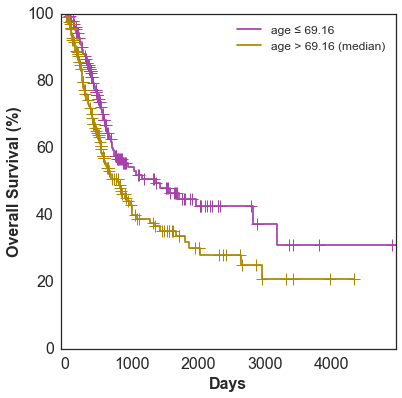

In [74]:
blca_cohort.plot_survival(on='age')

Or we could manually set a threshold value:

Missing age for 1 patients: from 412 to 411
# no condition 43
# with condition 368


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00273 |              8.979 |      Reject Null    |        True       
>

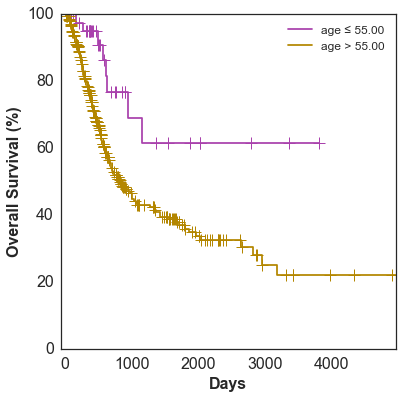

In [76]:
blca_cohort.plot_survival(on='age', threshold=55)

Finally, we could plot an alternative outcome such as `PFS`:

Missing age for 1 patients: from 412 to 411
# no condition 206
# with condition 205


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00372 |              8.417 |      Reject Null    |        True       
>

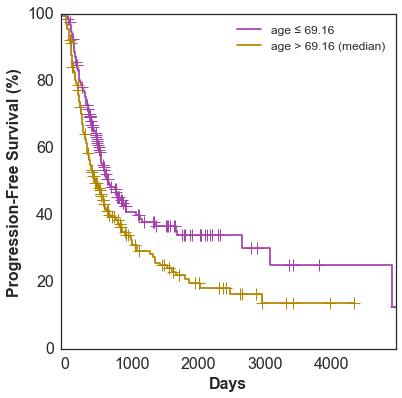

In [77]:
blca_cohort.plot_survival(on='age', how='pfs')

To plot by covariates _other_ than those encoded in the data, we could pass a function in lieu of a covariate name.

# no condition 24
# with condition 388


<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.21231 |              1.556 |  Cannot Reject Null |       False       
>

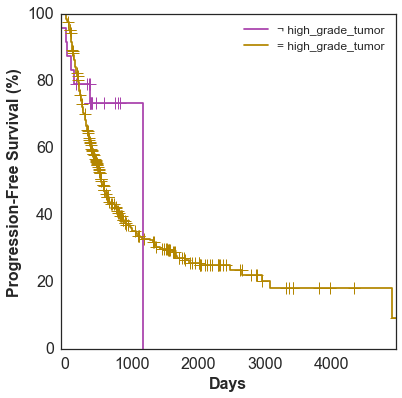

In [78]:
def high_grade_tumor(row):
    return row['tumor_grade']=='High Grade'
blca_cohort.plot_survival(high_grade_tumor, how='pfs')

## Summarize values by Benefit

Alternatively, we might want to analyze our data by comparing values among benefit vs. no-benefit patients.

There are a few different options for analyzing covariates for benefit:
    
### fisher's exact / mann-whitney, depending on sample size

Missing age for 1 patients: from 412 to 411
Mann-Whitney test: U=24509.5, p-value=0.000612011676661 (two-sided)


MannWhitneyResults(U=24509.5, p_value=0.000612011676661, sided_str='two-sided')

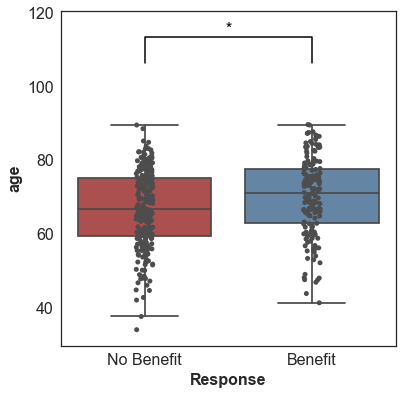

In [79]:
blca_cohort.plot_benefit('age')

high_grade_tumor  False  True 
Response                      
Benefit               8    161
No Benefit           16    227
Fisher's Exact Test: OR: 0.704968944099, p-value=0.523808531569 (two-sided)


FishersExactResults(oddsratio=0.704968944099, p_value=0.523808531569, sided_str='two-sided')

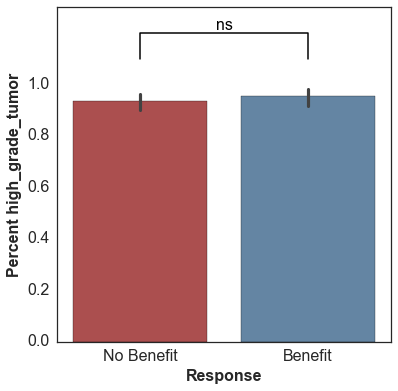

In [80]:
blca_cohort.plot_benefit(high_grade_tumor)

### ROC curve analysis

Like the above-mentioned analysis, the ROC curve analysis summarize the PPV and NPV for `Benefit`, over the range of values observed for the covariate.

Missing age for 1 patients: from 412 to 411
age, Bootstrap (samples = 100) AUC:0.603194683302, std=0.0274750432517


(0.60319468330243797, [<matplotlib.lines.Line2D at 0x119369f90>])

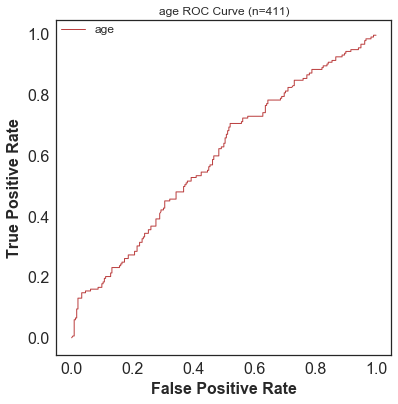

In [85]:
blca_cohort.plot_roc_curve('age')

In [ ]:
blca_cohort.plot_correlation('age', '')

## further analysis

To support other analysis routines, there is an `as_dataframe()` function which will return a summarized dataframe for analysis. 

In [86]:
df = blca_cohort.as_dataframe()

If we had included genotyped variants or other sample data, this dataframe would include those same data summaries.

Next we will go through an example using this process.